## CNN from scratch: Demo

<br> Here is a demo for my NumPy-based, PyTorch-style CNN model. I tried to replicate some functions in the torch library like nn.Sequential, nn.Conv2d and Autograd. You might find some of the expression in this program quite familiar. By the way, my favourite one is loss.backward(). :)

<br> Training this model for 1 epoch takes roughly 7 minutes on my Apple M1 chip, while training an equivalent model using PyTorch takes 20 seconds. 

<br> ---------------------------
<br> CNN architechture: LeNet
<br> Datasets: MNIST 
<br> Training duration: 1 epoch 
<br> Test accuracy: ~97% 
<br> ---------------------------

<br> Note that I replaced the sigmoid in the original LeNet with ReLU, and used MaxPooling rather than AveragePooling. Other model specs are completely the same.

### Main 

In [22]:
from dataset import get_data_from_torchvision_datasets
from CNN_lib import Linear, Conv2d, MaxPool2d, ReLU, Flatten, Sequential, Cross_entropy, SGD, DataLoader
import numpy as np
import time

# download dataset from torchvision datasets, then convert to numpy arrays
print('Loading datasets...')
train_data, train_label, test_data, test_label = get_data_from_torchvision_datasets()
print(f'Training data: {train_data.shape[0]} {train_data.shape[1]}x{train_data.shape[2]} images')
print(f'Testing data: {test_data.shape[0]} {test_data.shape[1]}x{test_data.shape[2]} images')

# define model: Using a LeNet-like structure, mostly the same, except using ReLU instead of sigmoid
# and maxpooling rather than average pooling
model = Sequential(
    Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    Linear(400, 120),
    ReLU(),
    Linear(120, 84),
    ReLU(),
    Linear(84, 10),
    )

print('='*70)

# define training dataloader
trainloader = DataLoader(train_data, train_label, batch_size=10, shuffle=True)

# use SGD optimizer
optimizer = SGD(model, lr=1e-4)

epochs = 1
iteration = 0
starting_time = time.time()

for _ in range(epochs):
    for data in trainloader:
        images = data[0]
        labels = data[1]
        # forward
        loss = Cross_entropy(model, images, labels)
        # backward
        loss.backward()
        # update
        optimizer.step()

        if iteration % 1000 == 0:
            print(f'Iteration: {iteration} | Loss: {loss.item():.3f}')
        iteration += 1

print('='*70)
print('Traninig completed.')
print(f'Total training time:{time.time() - starting_time:.4f}s')
print(f'Training iteration :', iteration)
# 1 epoch of training takes about 7 minutes on Apple M1 chip

Loading datasets...
Training data: 60000 28x28 images
Testing data: 10000 28x28 images
Iteration: 0 | Loss: 2.642
Iteration: 1000 | Loss: 0.077
Iteration: 2000 | Loss: 0.005
Iteration: 3000 | Loss: 0.085
Iteration: 4000 | Loss: 0.004
Iteration: 5000 | Loss: 0.175
Traninig completed.
Total training time:430.3494s
Training iteration : 6000


### Model information

In [23]:
print(model)

Sequential( 
  Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=((2, 2)))
  ReLU()
  MaxPool2d(kernel_size=2, stride=2, padding=0)
  Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=((0, 0)))
  ReLU()
  MaxPool2d(kernel_size=2, stride=2, padding=0)
  Flatten(start_dim=1, end_dim=-1)
  Linear(in_features=400, out_features=120, bias=True)
  ReLU()
  Linear(in_features=120, out_features=84, bias=True)
  ReLU()
  Linear(in_features=84, out_features=10, bias=True)
)
Number of parameters : 61706


### Test accuracy

In [24]:
# compute accuracy using the whole 10000 test images

testloader = DataLoader(test_data, test_label, batch_size=1000, shuffle=False)
test_accuracy = []
for data in testloader:
    images, labels = data
    test_accuracy.append(np.mean(np.argmax(model(images), axis=1) == labels))

test_accuracy = np.mean(test_accuracy)
print('-'*30)
print(f'test_accuracy : {test_accuracy*100:.2f}%')
print('-'*30)

------------------------------
test_accuracy : 96.54%
------------------------------


### Classify images with trained model

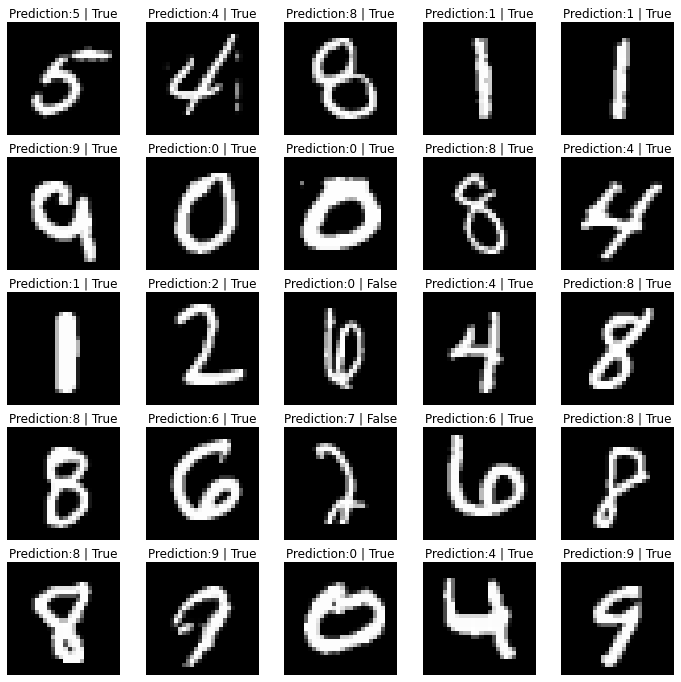

In [ ]:
import matplotlib.pyplot as plt

cols, rows = 6, 6,
testloader = DataLoader(test_data, test_label, batch_size=cols*rows, shuffle=True)
image_data, label_data = testloader[0]

figure = plt.figure(figsize=(12, 12))
for i in range(1, cols * rows + 1):
    predicted_label = np.argmax(model(image_data[i-1].reshape(1, 1, 28, 28)))
    image = np.squeeze(image_data[i-1])
    # prediction correct -> true; incorrect -> false
    if_correct = (predicted_label==label_data[i-1])
    figure.add_subplot(rows, cols, i)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'Prediction:{predicted_label} | {if_correct}')

### Time consumption for for each forward and backward pass in each layer

In [26]:
print('\t\tforward\t\tbackward')
for layer, i in zip(model.layers, model.forward_time):
    print(f'{layer.name}|\t{model.forward_time[i]:.3f}s\t\t{model.backward_time[i]:.3f}s')
print('-'*40)
print(f'Total forward + backward time : {sum(model.forward_time[i]+model.backward_time[i] for i in model.forward_time):.4f}s')

		forward		backward
Conv2d    |	84.082s		219.208s
ReLU      |	0.633s		0.887s
MaxPool2d |	10.466s		47.192s
Conv2d    |	17.026s		48.232s
ReLU      |	0.287s		0.755s
MaxPool2d |	3.105s		8.497s
Flatten   |	0.189s		0.026s
Linear    |	1.004s		1.584s
ReLU      |	0.074s		0.122s
Linear    |	0.196s		0.345s
ReLU      |	0.045s		0.115s
Linear    |	0.056s		0.192s
----------------------------------------
Total forward + backward time : 444.3176s
